# **In this Lab, there is one Exercise at the End. **
# **DEADLINE : 26TH NOVEMBER 2024, 11 AM **

# **Submission Link:**
 Form: https://forms.gle/q6yoABQebA5CEiza7

An autoencoder, also known as autoassociator or Diabolo networks, is an artificial neural network employed to recreate the given input. It takes a set of unlabeled inputs, encodes them and then tries to extract the most valuable information from them. They are used for feature extraction, learning generative models of data, dimensionality reduction and can be used for compression.

Autoencoders are based on Restricted Boltzmann Machines, are employed in some of the largest deep learning applications. They are the building blocks of Deep Belief Networks (DBN).

An autoencoder can be divided in two parts, the encoder and the decoder.

The encoder needs to compress the representation of an input. In this case we are going to reduce the dimension. The decoder works like encoder network in reverse. It works to recreate the input, as closely as possible. This plays an important role during training, because it forces the autoencoder to select the most important features in the compressed representation.

| **Feature**       | **CAEs**                        | **VAEs**                         |
|--------------------|----------------------------------|-----------------------------------|
| **Objective**      | Reconstruction                  | Generative modeling              |
| **Latent Space**   | Deterministic                   | Probabilistic                    |
| **Loss Function**  | Reconstruction only             | Reconstruction + KL Divergence   |
| **Sampling**       | Not designed for sampling       | Latent space designed for sampling |
| **Applications**   | Denoising, feature extraction   | Data generation, synthesis       |


In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [ ]:
# Create training and test dataloaders

num_workers = 0
# setting num_workers to a positive number would spawn that many data_loader processes, and use the multiple processes created to load the data. This way computation of the main code doesn't stop

# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

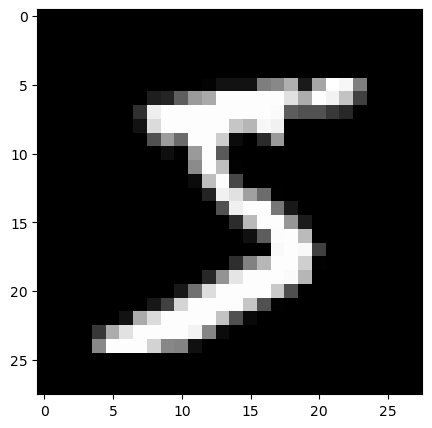

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter) #common mistake is using dataiter.next() which doesn't work anymore
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# **Variational Autoencoders**

In [ ]:
cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [ ]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parameters of simple tractable normal distribution "q"

        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [ ]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, 784)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

Start training VAE...
	Epoch 1 complete! 	Average Loss:  29.88299013204597
	Epoch 2 complete! 	Average Loss:  24.237673246225306
	Epoch 3 complete! 	Average Loss:  23.210719512705406
	Epoch 4 complete! 	Average Loss:  22.586419849910907
	Epoch 5 complete! 	Average Loss:  22.23794223115062
	Epoch 6 complete! 	Average Loss:  22.024677113236965
	Epoch 7 complete! 	Average Loss:  21.869545449883034
	Epoch 8 complete! 	Average Loss:  21.762588773894684
	Epoch 9 complete! 	Average Loss:  21.651400105373668
	Epoch 10 complete! 	Average Loss:  21.56826337823871
	Epoch 11 complete! 	Average Loss:  21.507603404422568
	Epoch 12 complete! 	Average Loss:  21.46146590001029
	Epoch 13 complete! 	Average Loss:  21.38950726414013
	Epoch 14 complete! 	Average Loss:  21.355380294815067
	Epoch 15 complete! 	Average Loss:  21.314221929770863
	Epoch 16 complete! 	Average Loss:  21.27437966057045
	Epoch 17 complete! 	Average Loss:  21.23605919298946
	Epoch 18 complete! 	Average Loss:  21.219308777160748
	Epo

Generating images from noise

In [ ]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [ ]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

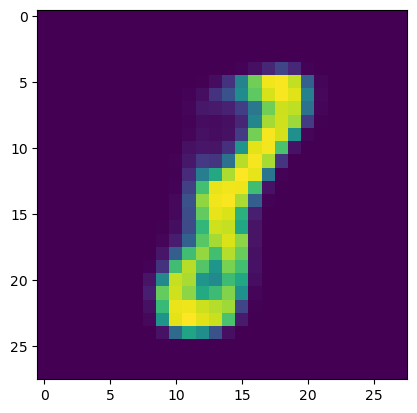

In [ ]:
show_image(generated_images, idx=12)


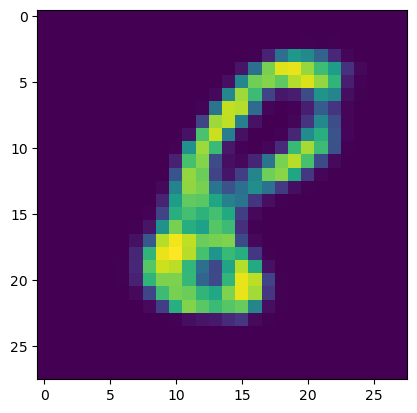

In [ ]:
show_image(generated_images, idx=10)


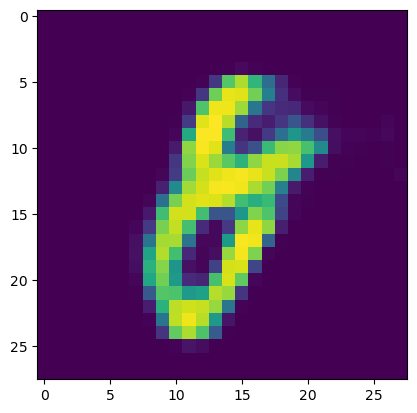

In [ ]:
show_image(generated_images, idx=16)


#Exercise: Modify the code to explore the effects of different types of noise in the latent space. Use two noise types other than the default Gaussian noise (torch.randn)

#For each noise type:

#Generate images from the decoder.
#Visualize and compare the generated images.

Use Poisson Noise and Uniform Noise for image generation.